# Project Proposal # 

## Introduction ##

Heart diseases refers to types of heart conditions in which their common symptoms vary from having heart attacks, arrhythmia (abnormal heart beats), to heart failure. Though these symptoms may exist for some people, many cannot be diagnosed unless experienced one of the conditions. Our question we would like to address is predicting the presence of heart disease by working with four variables as the predictors. The four variables are age, maximum heart rate, resting blood pressure, and cholesterol (These predictors are subjected to change as we move towards the end of the course as we learn how to find which are the best predictors). The accuracy of our model could be helpful as being the preliminary test to see if a patient needs further diagnosis before clinicians coming up with suitable treatment models for that patient.  For our project, we chose to focus on a dataset from UCI Machine Learning that contains data pulled from Hungary, Cleveland, Switzerland, and Longbeach that we found on Kaggle. https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset. 



The dataset includes 14 columns:
- age
- sex
- chest pain type (4 values; 0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic)
- trestbps: resting blood pressure
- chol: serum cholestoral in mg/dl
- fbs: fasting blood sugar > 120 mg/dl
- restecg: resting electrocardiographic results (values 0,1,2)
- thalach: maximum heart rate achieved
- exang: exercise induced angina
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
- target: presence of heart disease, 0 = False, 1 = True


In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
heart_data <- read_csv(file = "heart.csv")

heart_data

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


In [3]:
#Check to see if there is any n/a value in the dataset
na_check <- heart_data |>
     map_df(is.na) |>
     map_df(sum)

na_check

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
heart_data  <- heart_data |>
    mutate(sex = as_factor(sex), target = as.logical(target)) |>
    select(age, sex, chol, trestbps, thalach, target)

colnames(heart_data) <- c("age", "sex", "cholesterol", "rest_bp", "max_heart_rate", "disease_present")

# changes 1 to male and 0 to female
levels(heart_data$sex) <- c("female", "male")
# changes disease_present to true/false (0 = false, 1 = true)
levels(heart_data$disease_present) <- c(FALSE, TRUE)

heart_data

age,sex,cholesterol,rest_bp,max_heart_rate,disease_present
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>
52,male,212,125,168,FALSE
53,male,203,140,155,FALSE
70,male,174,145,125,FALSE
⋮,⋮,⋮,⋮,⋮,⋮
47,male,275,110,118,FALSE
50,female,254,110,159,TRUE
54,male,188,120,113,FALSE


In [5]:
set.seed(2106)
    
    
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease_present)
heart_train <- training(heart_split)
heart_testing <- testing(heart_split)

heart_explore <- heart_train |>
    group_by(sex, disease_present) |>
    summarize(count = n(),
              avg_chol = mean(cholesterol),
              avg_age = round(mean(age)))

heart_explore

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,disease_present,count,avg_chol,avg_age
<fct>,<lgl>,<int>,<dbl>,<dbl>
female,FALSE,66,275.9091,59
female,TRUE,170,255.4941,55
male,FALSE,308,245.8474,56
male,TRUE,224,230.6518,51


- We can see that the data have an unequal amount of male and female as well as unequal distribution of male & female with/without heart disease. This can be seen as an unreliable method of prediction as it affect the true average cholesterol in group. Therefore, we need to preprocess the data before working with the model

In [6]:
heart_explore_counts <- heart_train |>
    group_by(disease_present) |>
    summarize(count = n(),
              percent = (n() / nrow(heart_train)) * 100)

heart_explore_counts

disease_present,count,percent
<lgl>,<int>,<dbl>
FALSE,374,48.69792
TRUE,394,51.30208


- The data set has almost equal amount of percentages of patients with heart disease and patients with no heart disease and it is beneficial to our model as we can have equal cases to train our model effectively.

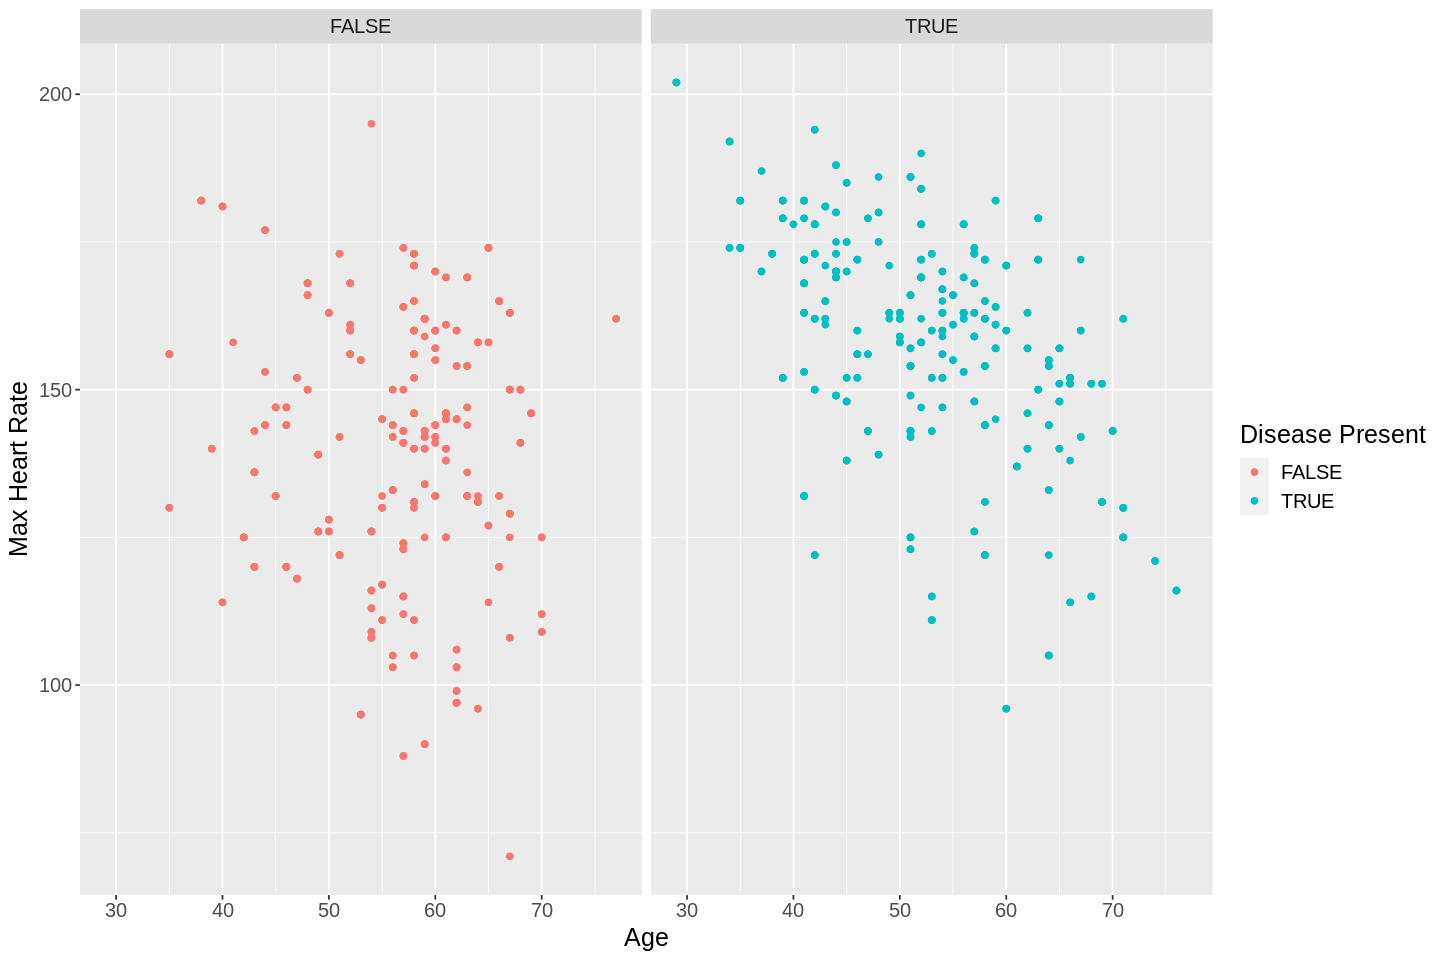

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8)

heart_rate_plot <- heart_train |>
    ggplot(aes(x = age, y = max_heart_rate, color = disease_present)) +
    geom_point() +
    labs(x = "Age", y = "Max Heart Rate", color = "Disease Present") +
    facet_grid(cols = vars (disease_present)) +
    theme(text = element_text(size = 15))

heart_rate_plot

- In here, we are trying to see whether having a higher max heart rate will increase the risk of having a heart disease. We can also assume that the younger/middle age group with high max heart rate a more prone to heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



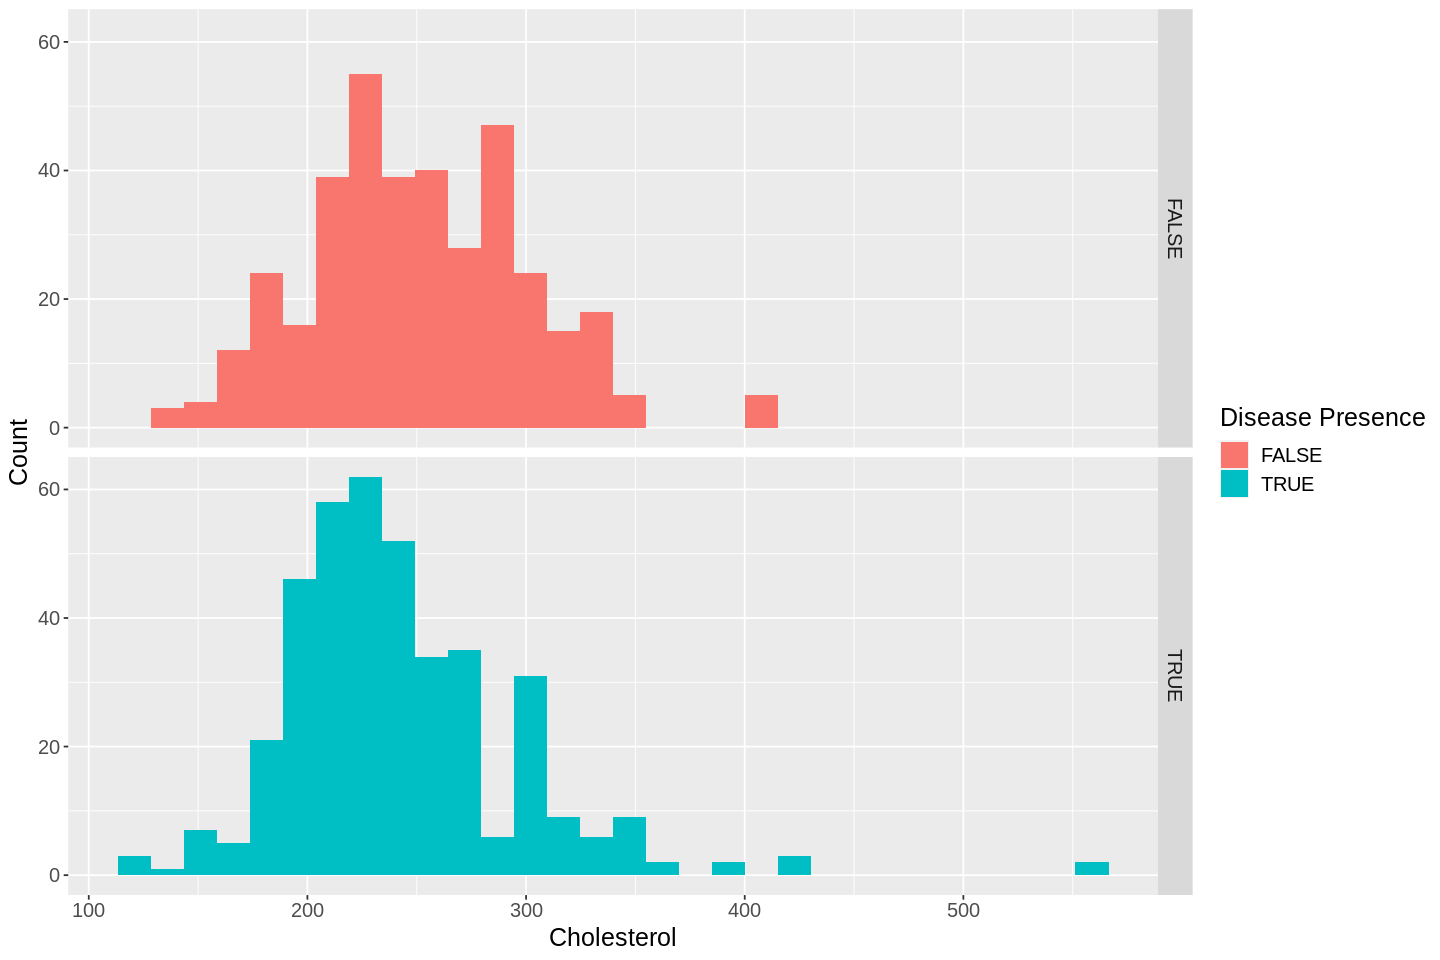

In [8]:
cholesterol_plot <- heart_train |>
    ggplot(aes(x = cholesterol, fill = disease_present)) +
    geom_histogram() +
    labs(x = "Cholesterol", y = "Count", fill = "Disease Presence") +
    facet_grid(rows = vars (disease_present)) +
    theme(text = element_text(size = 15))

cholesterol_plot

- We wanted to see whether having high cholesterol will build up the risk factor from having a heart disease. According to the CDC, high cholesterol especially the "bad" type of cholesterol build up and block the vessels and inducing heart attack. However, from the graph above, it does not seem to support the claim. Cholesterol by itself could not be an accurate predictor for the presence of heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



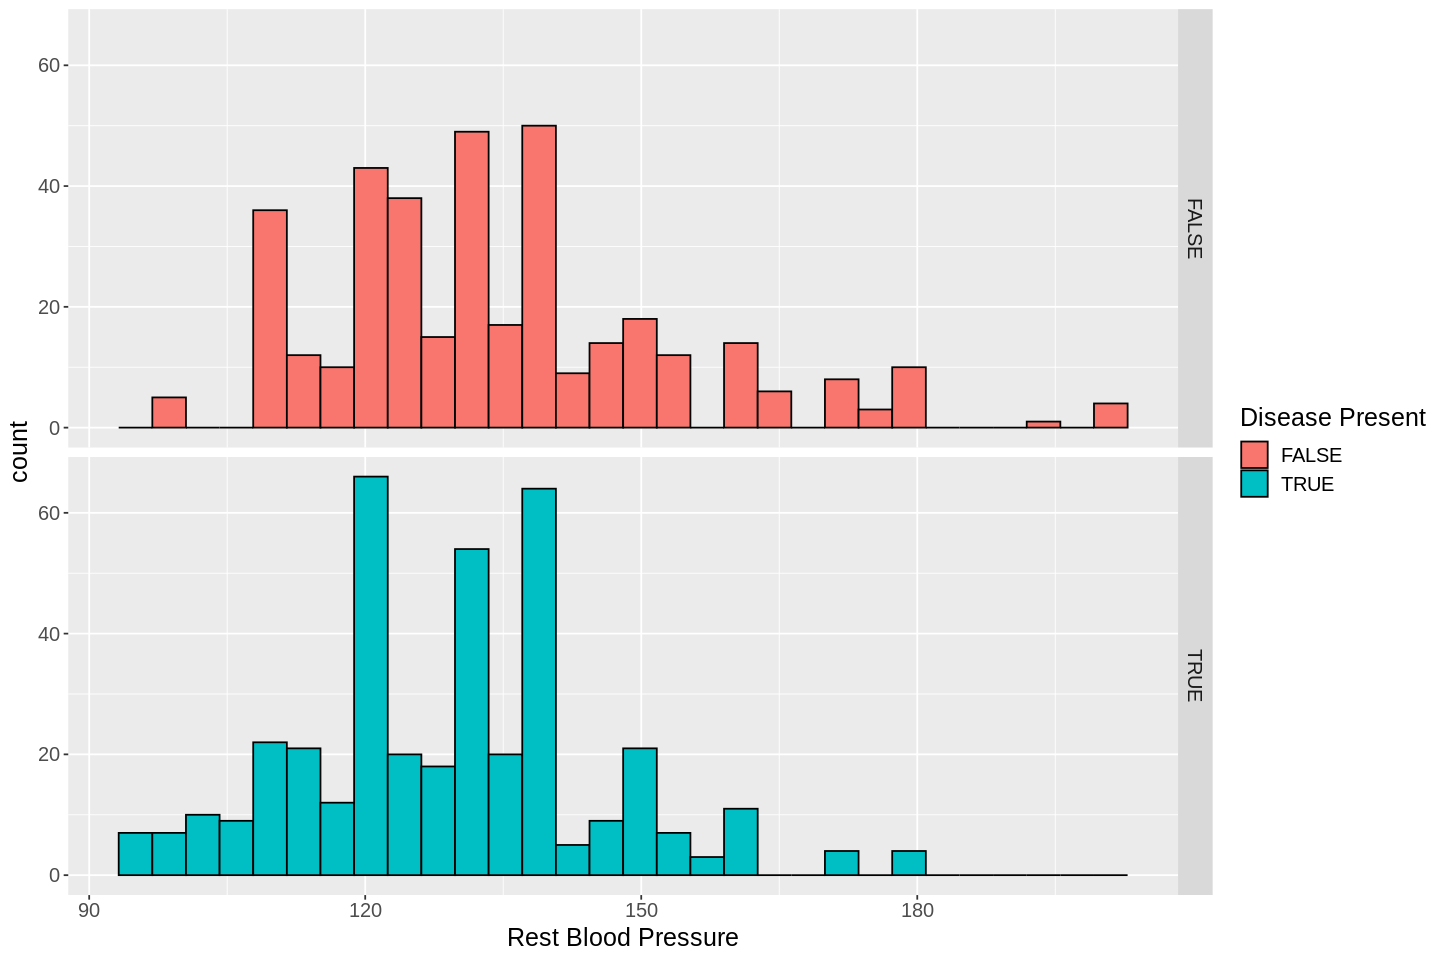

In [9]:
restbp_plot <- heart_train |>
    ggplot(aes(x = rest_bp,fill = disease_present)) +
    geom_histogram(color = "black", position = "dodge") +
    labs(x = "Rest Blood Pressure", fill = "Disease Present") +
    facet_grid(rows = vars (disease_present)) +
    theme(text = element_text(size = 15))

restbp_plot


- We want to see whether higher restingblood pressure is associated with higher chance of getting heart disease. From the graph above, the presence of heart disease is relatively high when the resting blood pressure is above 120. 

All together, we want to try out the 4 variables age, maximum heart rate, resting blood pressure, and cholesterol as our predictor for our model. We will also do preprocessing steps to make sure that our training data is centered and scaled. Furthermore, we will also be tuning our K to avoid overfitting and underfitting.

## References

https://www.cdc.gov/cholesterol/myths_facts.htm